#### Code for NWchem-Qiskit Driver
##### 1. import package

In [24]:
import numpy as np
import json
import sys
import yaml
import os
import matplotlib.pyplot as plt
import pylab


from qiskit_nwchem_driver import nwchem_driver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.mappers.qubit_mapper import QubitMapper

from qiskit.exceptions import QiskitError
from qiskit_algorithms import VQE
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit.primitives import BaseEstimator
from qiskit.primitives import StatevectorEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver.vqe_avg import run_vqe_with_averaging


from qiskit.visualization import plot_histogram
from qiskit.visualization.timeline import draw, IQXSimple
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeKyiv, FakeValenciaV2, FakeKyoto, FakeVigoV2
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from itertools import product



from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates, noise_free_gates, numerical_gates, almost_noise_free_gates 
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import fix_counts

from qiskit import transpile
from qiskit.visualization import plot_circuit_layout
from qiskit_aer import Aer, AerSimulator
from qiskit import transpile, assemble
from qiskit_aer import StatevectorSimulator
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit_aer.noise import NoiseModel
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator


from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.custom_ansatz import SDSfUCC, fUCC, tUPS



IBM_TOKEN='3199f66b51cb6ae29b8ea6b1033fc2918545d7426a4bd5e4e065123f19929d6d35e770b6e3f6b6e73f129baeee664be3a106d81f92b3a66be1f17ede8fbc83a6'


In [25]:
# data_dir = os.path.join("qe_files", "n2", "output")
# datafile = os.path.join(data_dir, "demo.out")
# data_file_yaml = os.path.join(data_dir, "demo.yaml")

data_dir = os.path.join("..","data","PW_LiH_data", "3x3_periodic", "NWChem",'1covo')
datafile = os.path.join(data_dir, "H1Li1-2.0.out")
data_file_yaml = os.path.join(data_dir, "H1Li1-2.0.yaml")

##### 2. nwchem output to yaml

In [26]:
data = extract_fields(datafile)
with open(data_file_yaml, 'w') as f:
    f.write(yaml.dump(data, default_flow_style=False)) 

##### 3. data to Qiskit electron structure problem class

In [27]:
driver = nwchem_driver.NWchem_Driver(data_file_yaml)
es_problem = driver.run()
hamiltonian  = es_problem.hamiltonian
print(hamiltonian)
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

h_ij up-down equal: True
eri up-down equal: True
eri up-(down-up) equal: False
eri (up-down)-(down-up) equal: True
Fermionic Operator
number spin orbitals=4, number terms=48
  0.0620810131 * ( +_0 +_2 -_2 -_0 )
+ -0.03120481085 * ( +_0 +_2 -_3 -_0 )
+ -0.03120481085 * ( +_0 +_3 -_2 -_0 )
+ 0.028375930725 * ( +_0 +_3 -_3 -_0 )
+ 0.028375930725 * ( +_0 +_0 -_1 -_1 )
+ 0.053516168575 * ( +_0 +_1 -_0 -_1 )
+ -0.03120481085 * ( +_0 +_2 -_2 -_1 )
+ 0.028375930725 * ( +_0 +_2 -_3 -_1 )
+ 0.053516168575 * ( +_0 +_3 -_2 -_1 )
+ -0.030104954625 * ( +_0 +_3 -_3 -_1 )
+ 0.053516168575 * ( +_1 +_0 -_1 -_0 )
+ 0.028375930725 * ( +_1 +_1 -_0 -_0 )
+ -0.03120481085 * ( +_1 +_2 -_2 -_0 )
+ 0.053516168575 * ( +_1 +_2 -_3 -_0 )
+ 0.028375930725 * ( +_1 +_3 -_2 -_0 )
+ -0.030104954625 * ( +_1 +_3 -_3 -_0 )
+ 0.028375930725 * ( +_1 +_2 -_2 -_1 )
+ -0.030104954625 * ( +_1 +_2 -_3 -_1 )
+ -0.030104954625 * ( +_1 +_3 -_2 -_1 )
+ 0.0518915698 * ( +_1 +_3 -_3 -_1 )
+ 0.0620810131 * ( +_2 +_0 -_0 -_2 )
+ -0.0312

##### 4. Mapping Hamiltonian to qubit

In [28]:
mapper = JordanWignerMapper()

In [29]:
hamiltonian_mapped =mapper.map(second_q_op)
print(hamiltonian_mapped)

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IZIZ', 'YYII', 'YYIZ', 'XXII', 'XXIZ', 'ZIII', 'ZIIZ', 'IIZI', 'IIZZ', 'IIYY', 'IZYY', 'IIXX', 'IZXX', 'XYXY', 'YYYY', 'XXYY', 'YXXY', 'XYYX', 'YYXX', 'XXXX', 'YXYX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.6482921 +0.j,  0.24387462+0.j,  0.24387462+0.j,  0.03104051+0.j,
  0.03175493+0.j,  0.01560241+0.j,  0.03175493+0.j,  0.01560241+0.j,
  0.06434841+0.j,  0.01418797+0.j,  0.06434841+0.j, -0.02675808+0.j,
  0.03175493+0.j,  0.01560241+0.j,  0.03175493+0.j,  0.01560241+0.j,
  0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j, -0.00628506+0.j,
 -0.00628506+0.j,  0.02047302+0.j,  0.02047302+0.j,  0.00628506+0.j,
  0.01505248+0.j,  0.01505248+0.j,  0.01418797+0.j,  0.01505248+0.j,
  0.01505248+0.j,  0.02594578+0.j, -0.02675808+0.j])


##### 5. specify ansatz

In [30]:
ansatz_uccsd = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )
print(type(ansatz_uccsd))

<class 'qiskit_nature.second_q.circuit.library.ansatzes.uccsd.UCCSD'>


##### 6. Add measurement

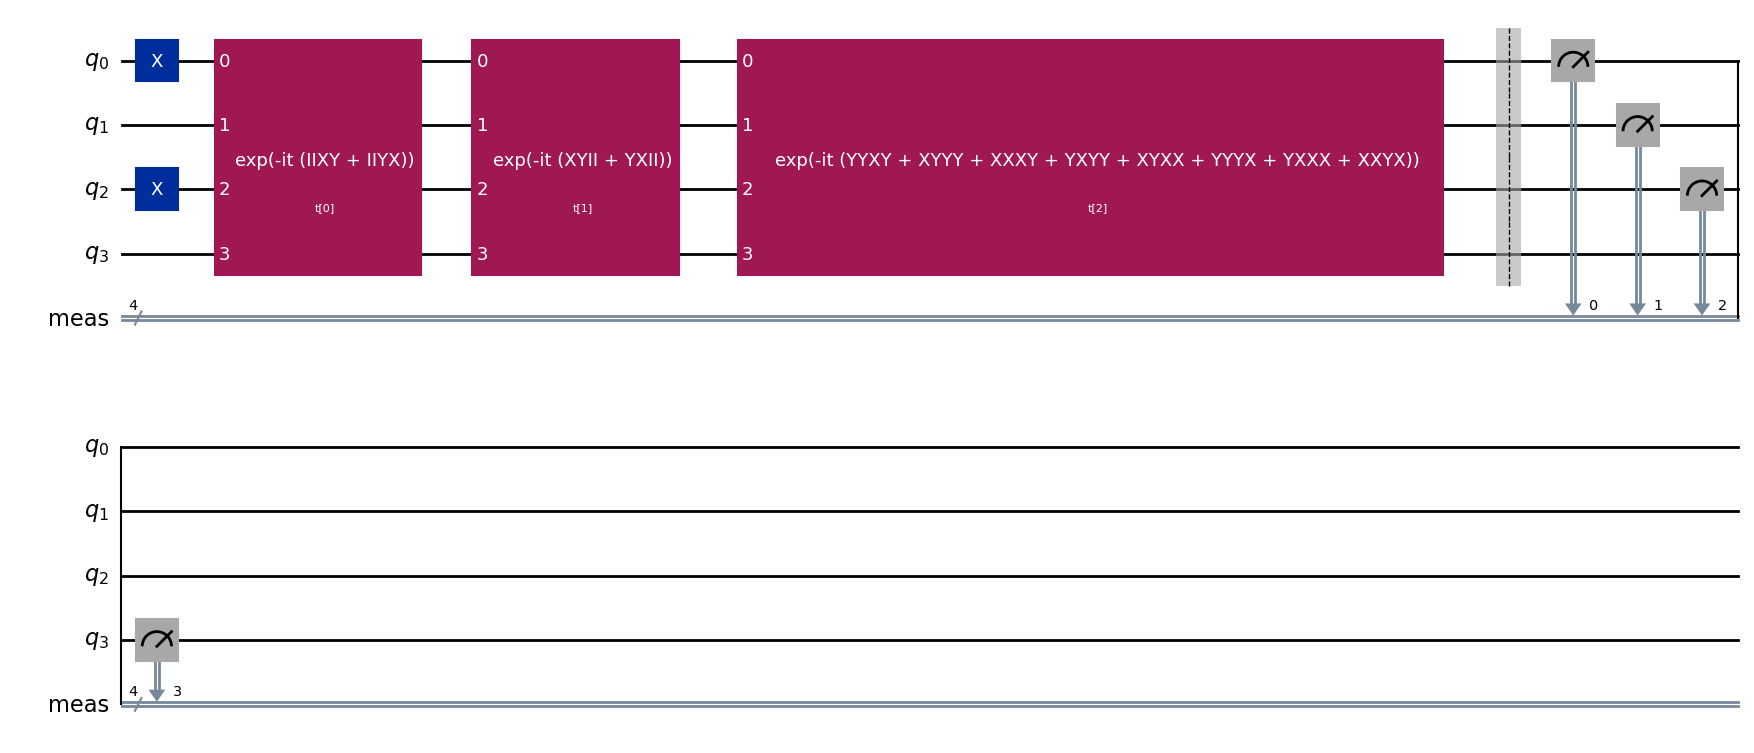

In [8]:

ansatz_circuit_uccsd = ansatz_uccsd.decompose()  
ansatz_circuit_uccsd.measure_all()
ansatz_circuit_uccsd.draw('mpl')  


##### 7. Define backend and transpile circuit

In [31]:
# directly with qiskit import a real device
provider = QiskitRuntimeService(channel= 'ibm_quantum', token=IBM_TOKEN)
provider.backends() 
backend_real = provider.backend('ibm_kyiv')

# fake backend without the use of the IBM_TOKEN to run the simulation
backend_fake = FakeKyiv()

n_qubit = 4
n_classic_bit = 4
linear_qubit_layout = [0,1,2,3] # linear layout
psi0 = [1] + [0] * (2**n_qubit-1) # starting state
shots = 100 # shots
device_param = DeviceParameters(linear_qubit_layout)
device_param.load_from_backend(backend_fake) # get parameters from the backend
device_param_lookup = device_param.__dict__() # get dict representation.
#print(device_param_lookup)

# transpilation of the circuit



RequestsApiError: "HTTPSConnectionPool(host='auth.quantum-computing.ibm.com', port=443): Max retries exceeded with url: /api/version (Caused by ResponseError('too many 503 error responses'))"

In [10]:
t_circ_uccsd = transpile(
    ansatz_circuit_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=42,
    scheduling_method='asap'
)


NameError: name 'ansatz_circuit_uccsd' is not defined

##### 8. Define parameters

In [19]:
print(t_circ_uccsd.parameters)
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=t_circ_uccsd.num_parameters)
t_circ_uccsd = t_circ_uccsd.assign_parameters(params)



ParameterView([ParameterVectorElement(t[0]), ParameterVectorElement(t[1]), ParameterVectorElement(t[2])])


##### 9. Define and run simulator with correspondent gate set

In [ ]:
sim_noise_ander = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_free_ander = MrAndersonSimulator(gates=noise_free_gates, CircuitClass=EfficientCircuit, parallel= False)
sim_noise_aer = AerSimulator.from_backend(backend_fake)
sim_free_aer =AerSimulator()




In [52]:
probs_noise_ander_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 


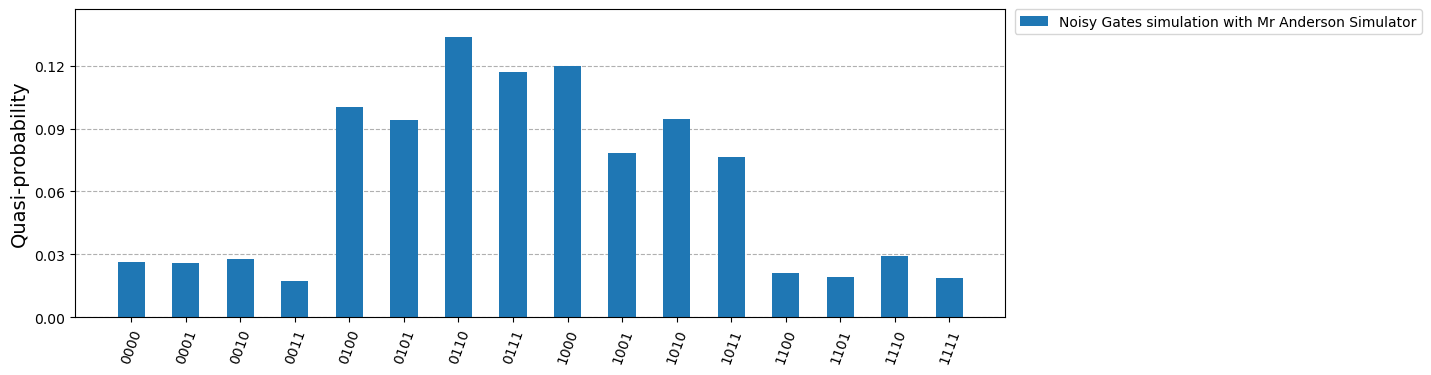

In [53]:
measured_qubit = n_classic_bit
counts_noise_ander_uccsd = fix_counts(probs_noise_ander_uccsd, n_classic_bit)
plot_histogram(counts_noise_ander_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [21]:
probs_free_ander_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

{'0000': np.float64(1.1926034088042294e-30), '0001': np.float64(8.223450573166925e-31), '0010': np.float64(1.2163007711400323e-29), '0011': np.float64(1.4313074821327033e-30), '0100': np.float64(1.7037739253021786e-29), '0101': np.float64(0.06076042974094352), '0110': np.float64(0.011334305171465156), '0111': np.float64(2.503179296968716e-30), '1000': np.float64(2.540378633844555e-29), '1001': np.float64(0.4574315473728755), '1010': np.float64(0.47047371771471574), '1011': np.float64(3.58993341633783e-30), '1100': np.float64(9.738495187694037e-31), '1101': np.float64(1.9378198581339313e-29), '1110': np.float64(9.630007248833868e-30), '1111': np.float64(1.9369180209694206e-30)}
{'0000': np.float64(1.1926034088042294e-30), '0001': np.float64(2.540378633844555e-29), '0010': np.float64(1.7037739253021786e-29), '0011': np.float64(9.738495187694037e-31), '0100': np.float64(1.2163007711400323e-29), '0101': np.float64(0.47047371771471574), '0110': np.float64(0.011334305171465156), '0111': np.f

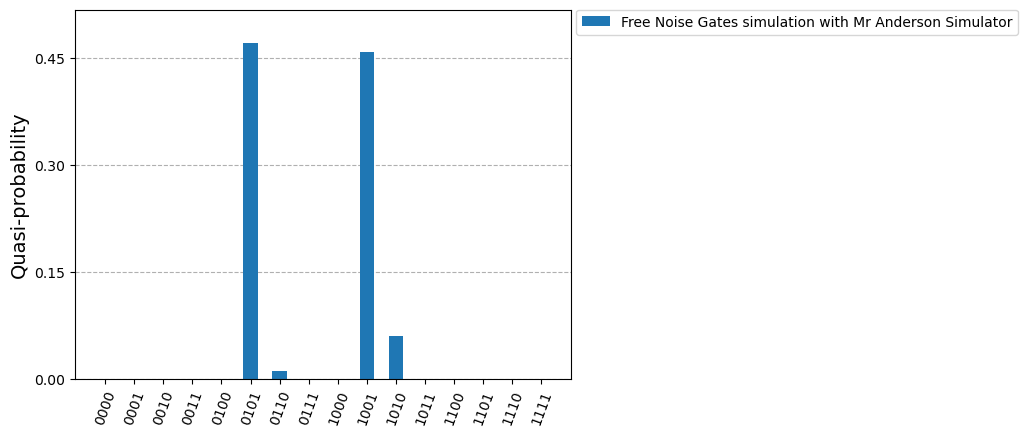

In [24]:
measured_qubit = n_classic_bit
counts_free_ander_uccsd = fix_counts(probs_free_ander_uccsd, n_classic_bit)
plot_histogram(counts_free_ander_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [75]:
probs_noise_aer_uccsd = sim_noise_aer.run(t_circ_uccsd, shots=10000).result()

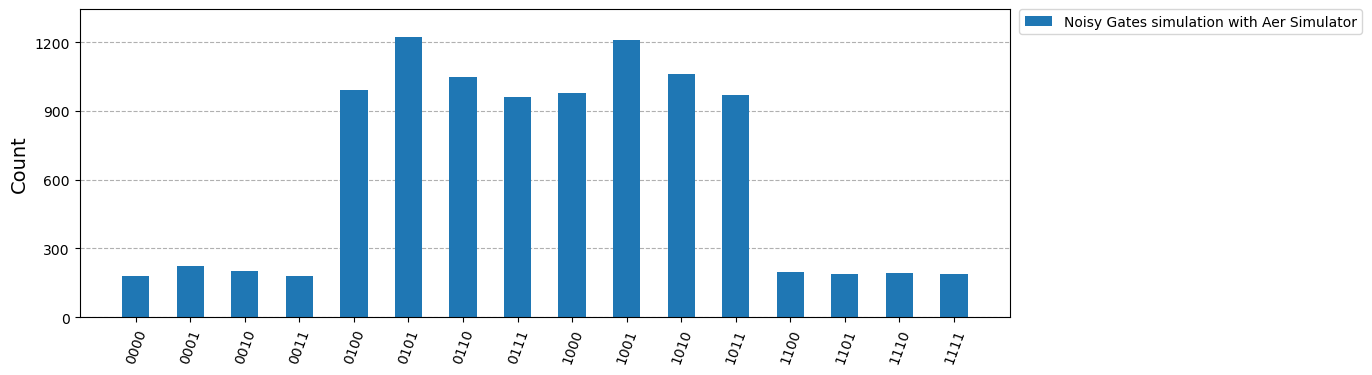

In [76]:
counts_noise_aer_uccsd = probs_noise_aer_uccsd.get_counts()
plot_histogram(counts_noise_aer_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [13]:
probs_free_aer_uccsd = sim_free_aer.run(t_circ_uccsd, shots=10000).result()

<class 'qiskit.result.counts.Counts'> {'0110': 122, '1010': 595, '1001': 4599, '0101': 4684}
['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_remove_space_underscore', 'bitstring_regex', 'clear', 'copy', 'creg_sizes', 'fromkeys', 'get', 'hex_outcomes', 'hex_raw', 'int_outcomes', 'int_raw', 'items', 'keys', 'memory_slots', 'most_frequent', 'pop', 'popitem', 'setdefault', 'shots', 'time_taken', 'update', 'values']
dict_items([('0110', 122), ('1010', 595), ('1001', 4599), ('0101', 4684)])


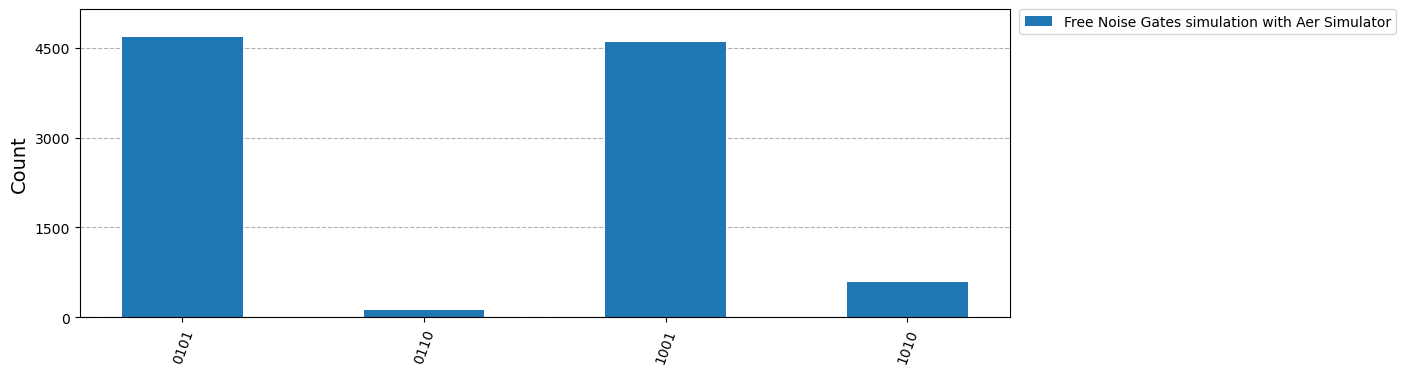

In [24]:
counts_free_aer_uccsd = probs_free_aer_uccsd.get_counts()
print(type(counts_free_aer_uccsd),counts_free_aer_uccsd)
print(dir(counts_free_aer_uccsd))
print(counts_free_aer_uccsd.items())
plot_histogram(counts_free_aer_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

##### 10. Constructing VQE and check results 

In [12]:
average_values_noisefree_uccsd, probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd, probs_free_aer_min_noisefree_uccsd, max_evaluations_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=2, maxiter=100, is_tUPS=False)

/tmp/ipykernel_306272/1686914082.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_uccsd, probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd, probs_free_aer_min_noisefree_uccsd, max_evaluations_noisefree_uccsd = run_vqe_with_averaging(ansatz_uccsd, Estimator(), mapper, es_problem, n_repeats=2, maxiter=100, is_tUPS=False)


     ┌─────────────────────────────┐
q_0: ┤0                            ├
     │                             │
q_1: ┤1                            ├
     │  EvolvedOps(t[0],t[1],t[2]) │
q_2: ┤2                            ├
     │                             │
q_3: ┤3                            ├
     └─────────────────────────────┘
{ParameterVectorElement(t[0]): np.float64(0.13604078009228807), ParameterVectorElement(t[1]): np.float64(0.13609253092948287), ParameterVectorElement(t[2]): np.float64(-0.07150908766904222)}
{ParameterVectorElement(t[0]): np.float64(0.13604078009228807), ParameterVectorElement(t[1]): np.float64(0.13609253092948287), ParameterVectorElement(t[2]): np.float64(-0.07150908766904222)}
{ParameterVectorElement(t[0]): np.float64(0.13604078009228807), ParameterVectorElement(t[1]): np.float64(0.13609253092948287), ParameterVectorElement(t[2]): np.float64(-0.07150908766904222)}
     ┌─────────────────────────────┐
q_0: ┤0                            ├
     │              

##### 11. Solve and obtain minimum energy and correspondent state

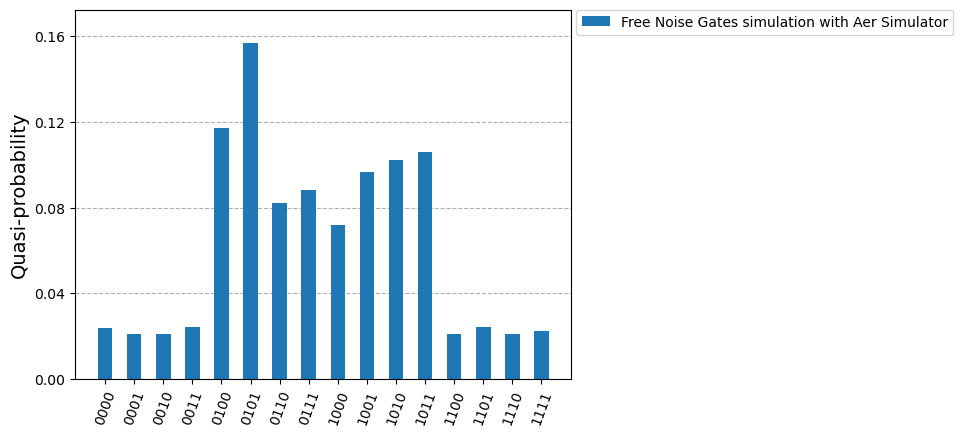

In [13]:
plot_histogram(probs_noise_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

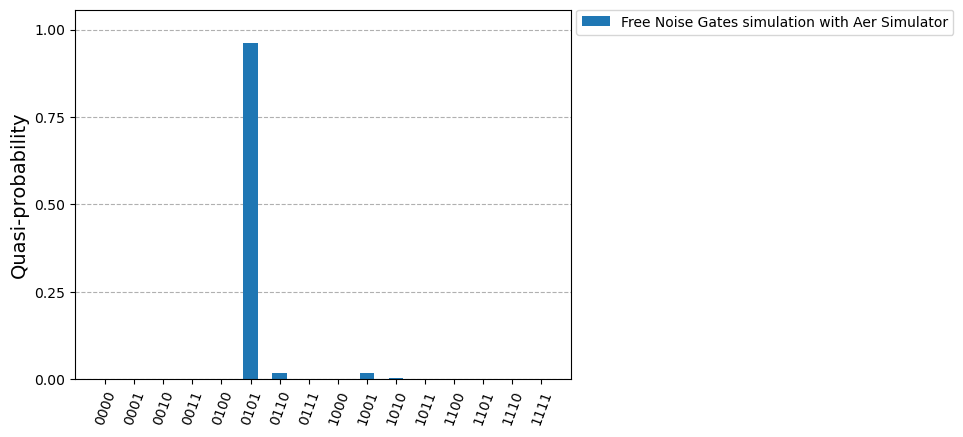

In [14]:
plot_histogram(probs_free_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

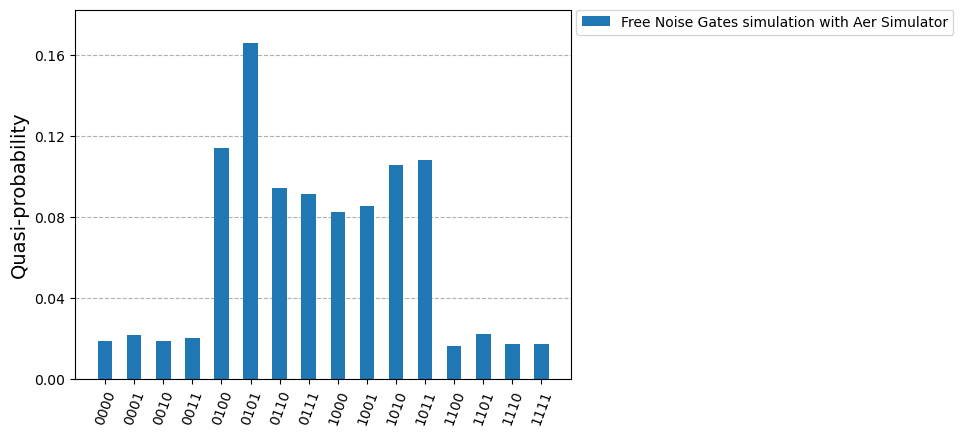

In [15]:
plot_histogram(probs_noise_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

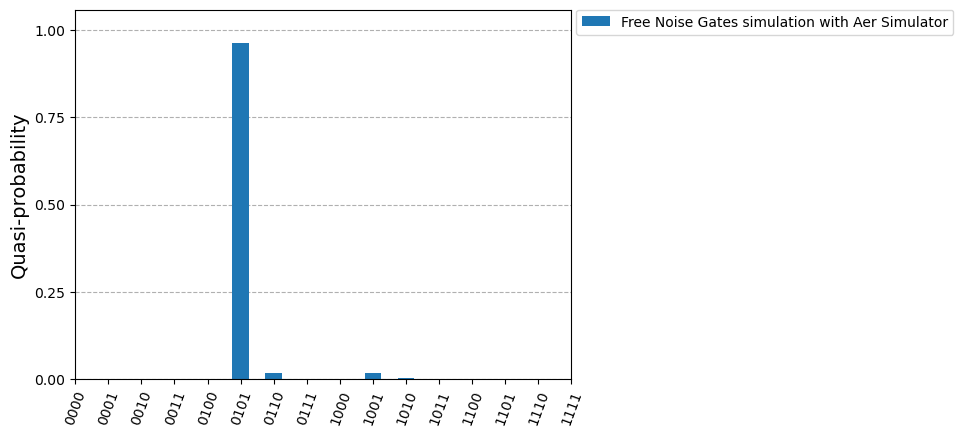

In [16]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noisefree_uccsd.values())

probs_full = {state: probs_free_aer_min_noisefree_uccsd.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noisefree_uccsd = quasi_probs_original
plot_histogram(probs_free_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])



In [ ]:
probs_to_plot = [probs_noise_ander_min_noisefree_uccsd, probs_free_ander_min_noisefree_uccsd, probs_noise_aer_min_noisefree_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisless VQE with UCCSD'
filename = 'histo_noisefree_ucccsd'

plot_histogram(probs_to_plot, bar_labels=True, legend=legend, title=title, filename = filename)

Averaged groundstate energy (Hartree units): -0.9453793375901705


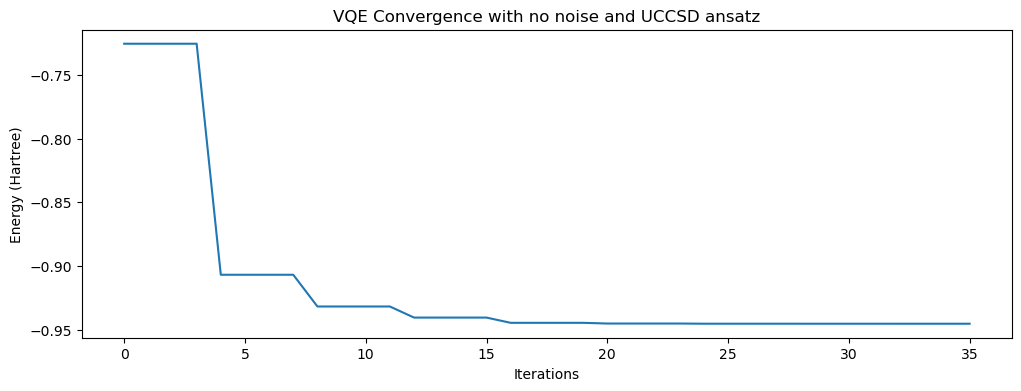

In [11]:
counts_noisefree_uccsd = np.arange(0, max_evaluations_noisefree_uccsd)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_uccsd, average_values_noisefree_uccsd, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and UCCSD ansatz")
pylab.savefig('vqe_noisfree_uccsd_avg_try')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_uccsd[-1])


##### 12. Add measurements to the new circuit defining ground state

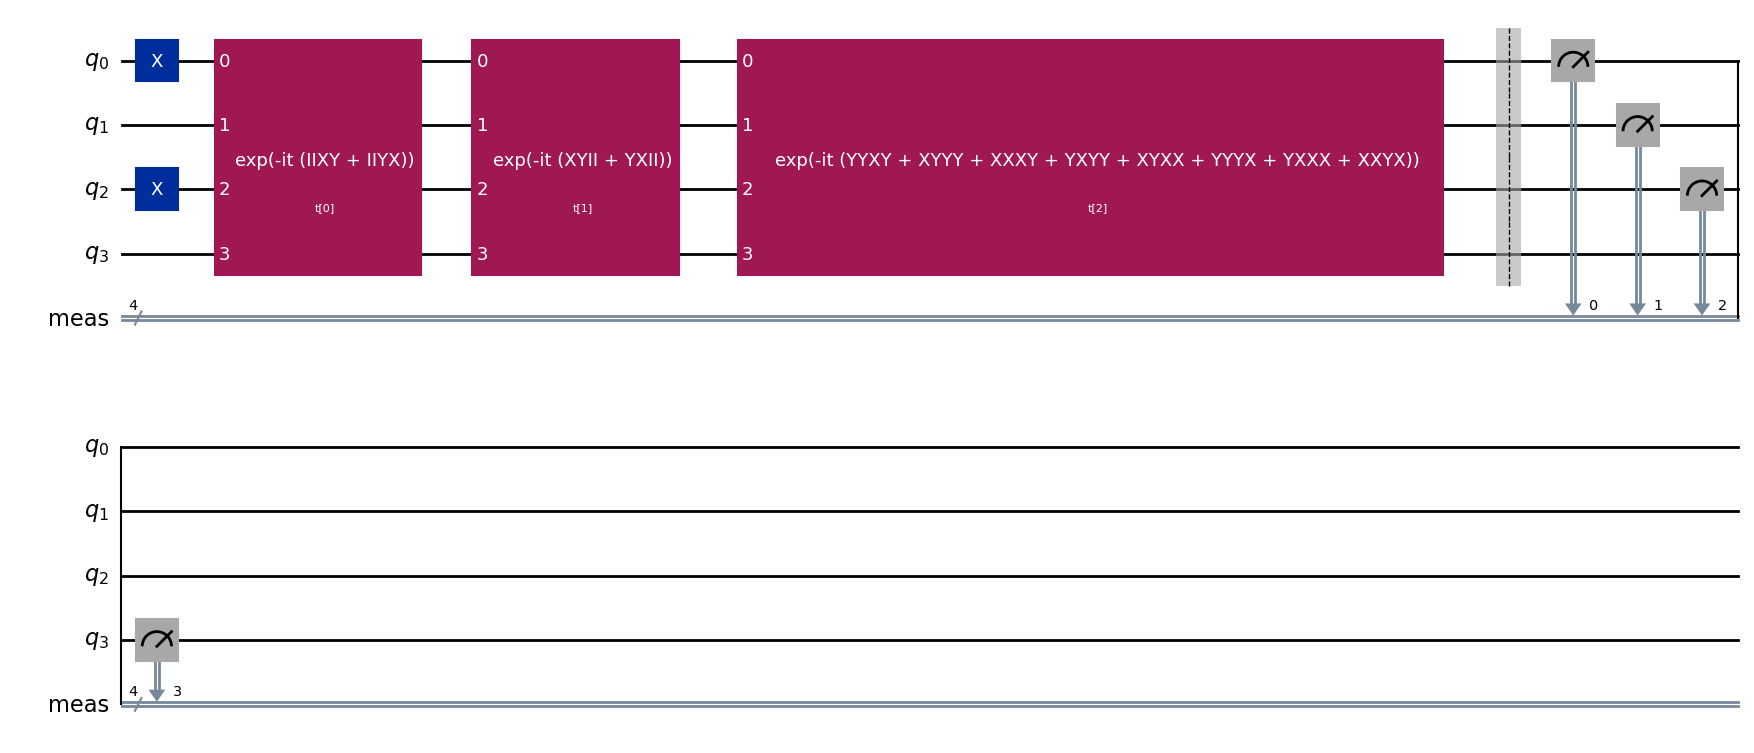

In [14]:
ansatz_circuit_min_noisefree_uccsd = optimal_circuit_noisefree_uccsd
ansatz_circuit_min_noisefree_uccsd = ansatz_circuit_min_noisefree_uccsd.decompose()  
ansatz_circuit_min_noisefree_uccsd.measure_all()
ansatz_circuit_min_noisefree_uccsd.draw('mpl')


##### 13. Define backend, transpile and assign new parameters as before

In [15]:
# transpilation of the circuit
t_circ_min_noisefree_uccsd = transpile(
    ansatz_circuit_min_noisefree_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)
#t_circ_min_noisefree_uccsd = t_circ_min_noisefree_uccsd.assign_parameters(parameters_noisefree_uccsd)

vqe_result = vqe_solver_noisefree_uccsd._build_vqe_result(
    ansatz = vqe_solver_noisefree_uccsd.ansatz,
    optimizer_result = result_noisefree_uccsd.optimizer_result,
    aux_operators_evaluated = result_noisefree_uccsd.aux_operators_evaluated,
    optimizer_time = result_noisefree_uccsd.optimizer_time
    )
print(parameters_noisefree_uccsd)
print(vqe_result.optimal_parameters)
t_circ_min_noisefree_uccsd = t_circ_min_noisefree_uccsd.assign_parameters(vqe_result.optimal_parameters)


{ParameterVectorElement(t[0]): np.float64(0.13599182331612097), ParameterVectorElement(t[1]): np.float64(0.13645662029406141), ParameterVectorElement(t[2]): np.float64(-0.0717547567972833)}
{ParameterVectorElement(t[0]): np.float64(0.13661162030771518), ParameterVectorElement(t[1]): np.float64(0.13627521155425573), ParameterVectorElement(t[2]): np.float64(-0.07142340002080201)}


##### 14. Define and run simulator with correspondent gate set

In [147]:
probs_noise_ander_min_noisefree_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 



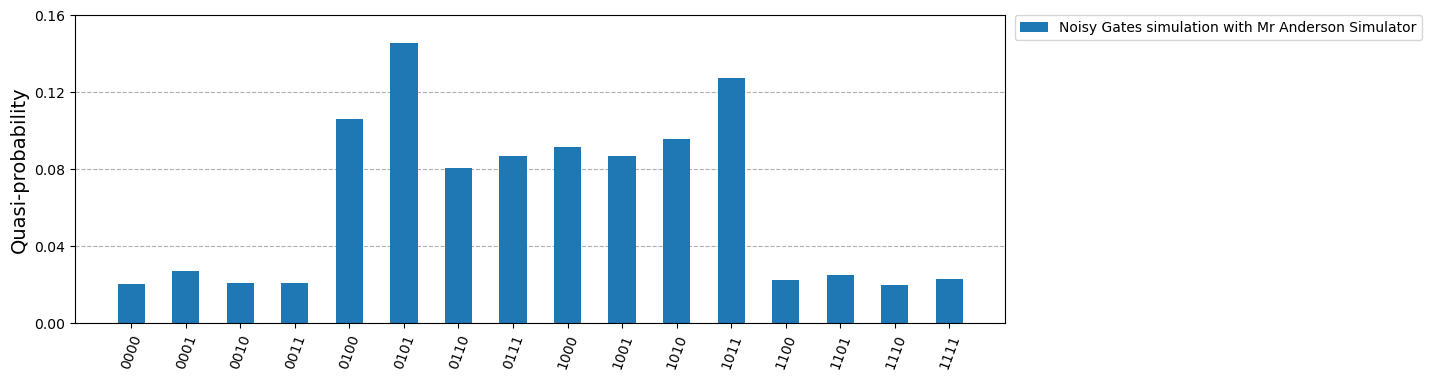

In [148]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noisefree_uccsd = fix_counts(probs_noise_ander_min_noisefree_uccsd, n_classic_bit)
plot_histogram(counts_noise_ander_min_noisefree_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [149]:
probs_free_ander_min_noisefree_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

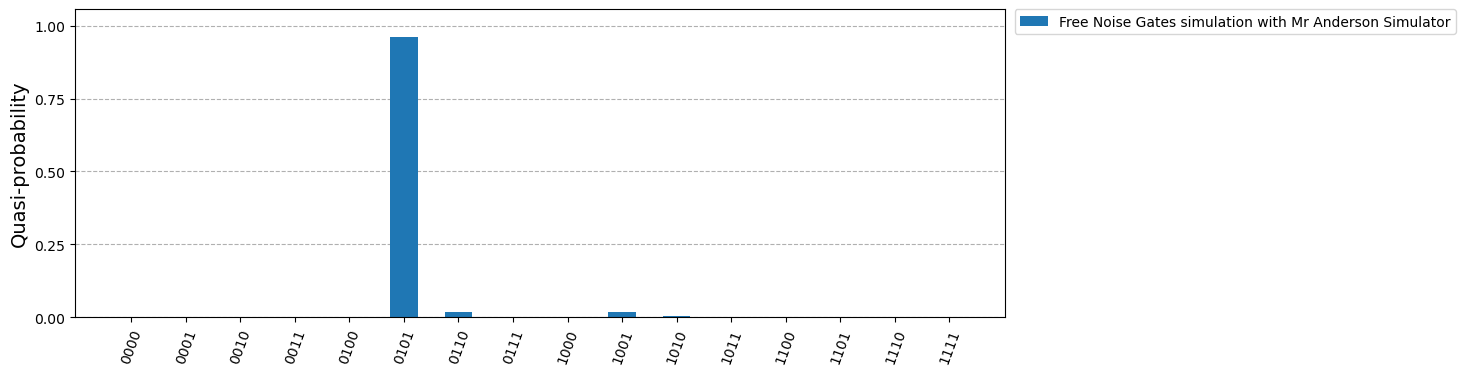

In [150]:
measured_qubit = n_classic_bit
counts_free_ander_min_noisefree_uccsd = fix_counts(probs_free_ander_min_noisefree_uccsd, n_classic_bit)
plot_histogram(counts_free_ander_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [151]:
probs_noise_aer_min_noisefree_uccsd = sim_noise_aer.run(t_circ_min_noisefree_uccsd, shots=10000).result()

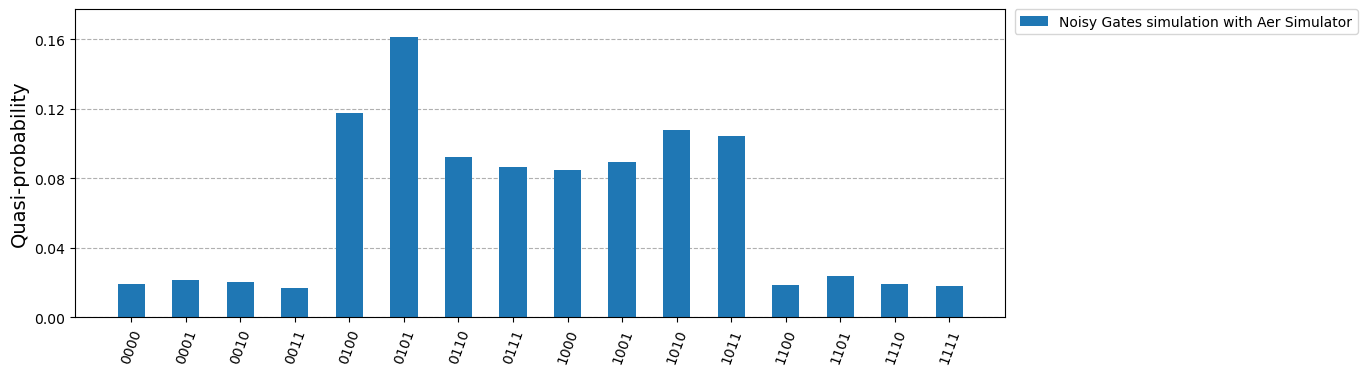

In [152]:
counts_noise_aer_min_noisefree_uccsd = probs_noise_aer_min_noisefree_uccsd.get_counts()

total_counts = sum(counts_noise_aer_min_noisefree_uccsd.values())
quasi_probs = {state: counts_noise_aer_min_noisefree_uccsd / total_counts for state, counts_noise_aer_min_noisefree_uccsd in counts_noise_aer_min_noisefree_uccsd.items()}

counts_noise_aer_min_noisefree_uccsd = quasi_probs

plot_histogram(counts_noise_aer_min_noisefree_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [153]:
probs_free_aer_min_noisefree_uccsd = sim_free_aer.run(t_circ_min_noisefree_uccsd, shots=10000).result()

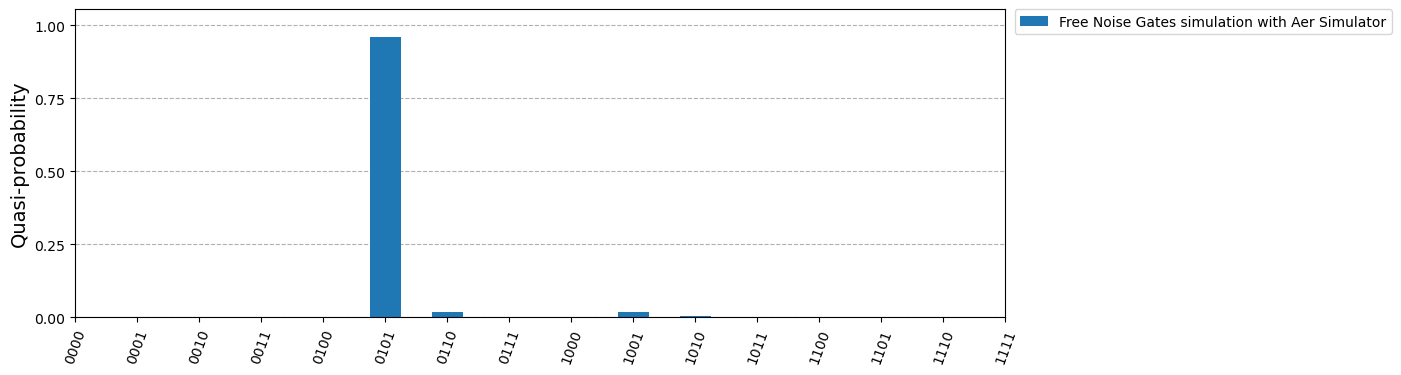

In [154]:
counts_free_aer_min_noisefree_uccsd = probs_free_aer_min_noisefree_uccsd.get_counts()

all_states = [format(i, f'0{n_qubit}b') for i in range(2**n_qubit)]
full_counts = {state: 0 for state in all_states}
full_counts.update(counts_free_aer_min_noisefree_uccsd)

total_counts = sum(full_counts.values())
quasi_probs = {state: full_counts / total_counts for state, full_counts in full_counts.items()}

counts_free_aer_min_noisefree_uccsd = quasi_probs

plot_histogram(counts_free_aer_min_noisefree_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [32]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [ ]:

average_values_noise_uccsd, probs_noise_ander_min_noise_uccsd, probs_free_ander_min_noise_uccsd, probs_noise_aer_min_noise_uccsd, probs_free_aer_min_noise_uccsd, max_evaluations_noise_uccsd = run_vqe_with_averaging(ansatz_uccsd, noisy_estimator, mapper, es_problem, n_repeats=50, maxiter=100, is_tUPS=False)


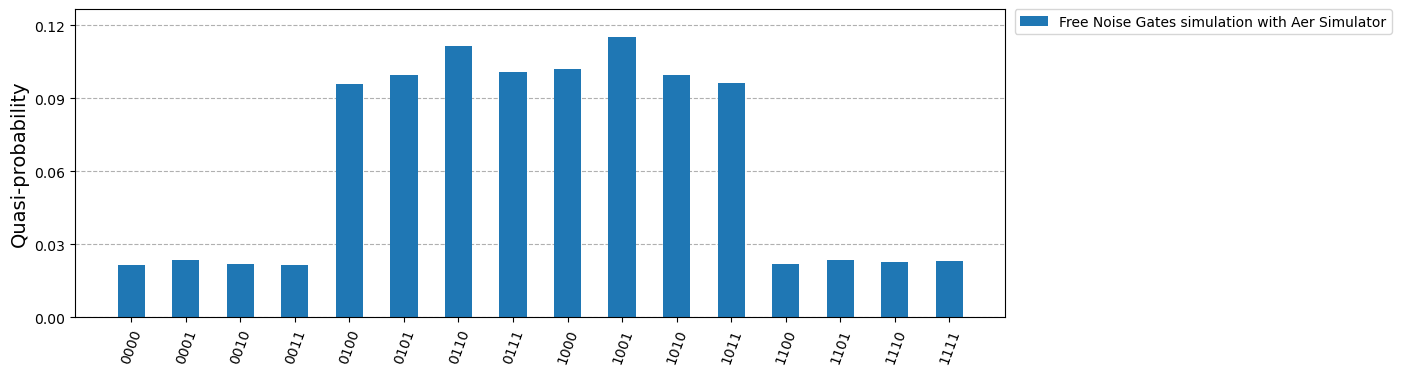

In [47]:
plot_histogram(probs_noise_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

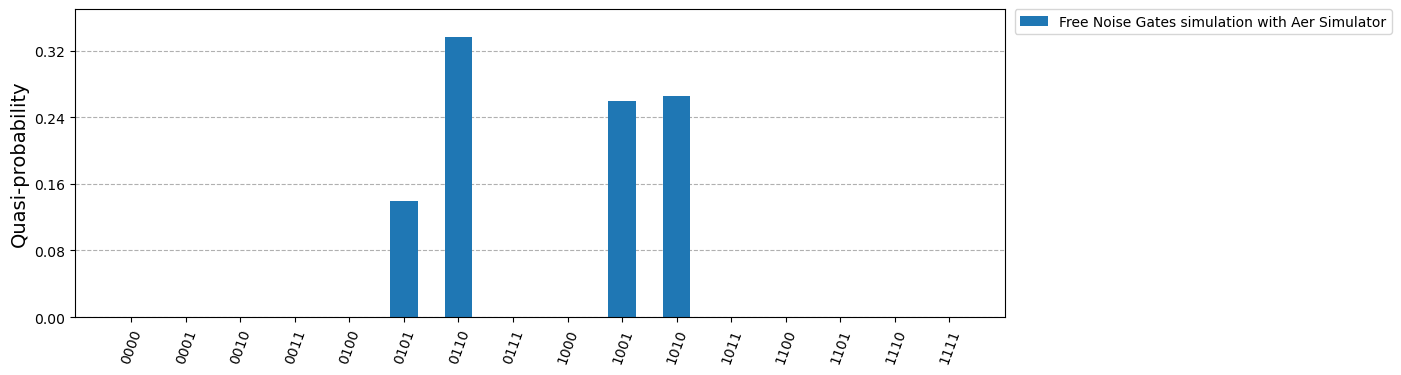

In [48]:
plot_histogram(probs_free_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

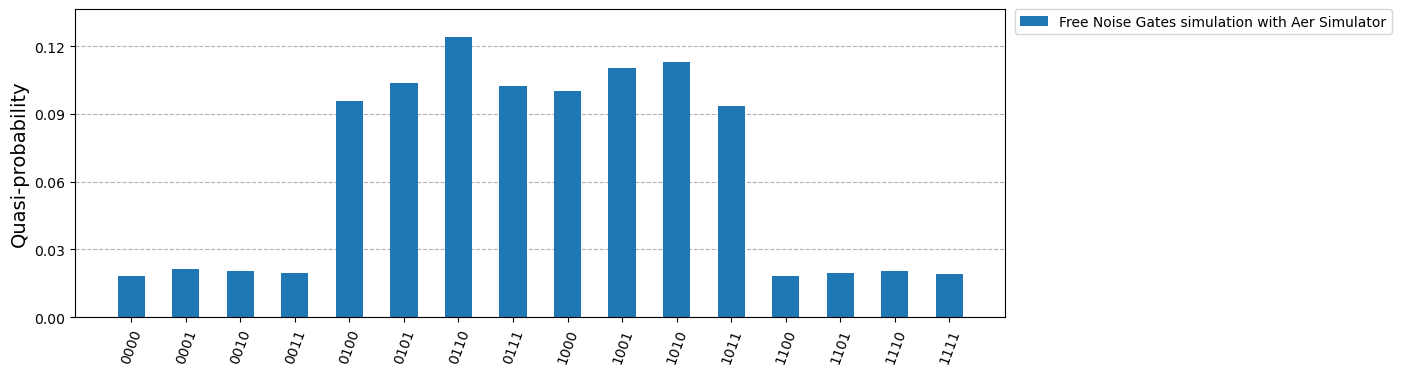

In [49]:
plot_histogram(probs_noise_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

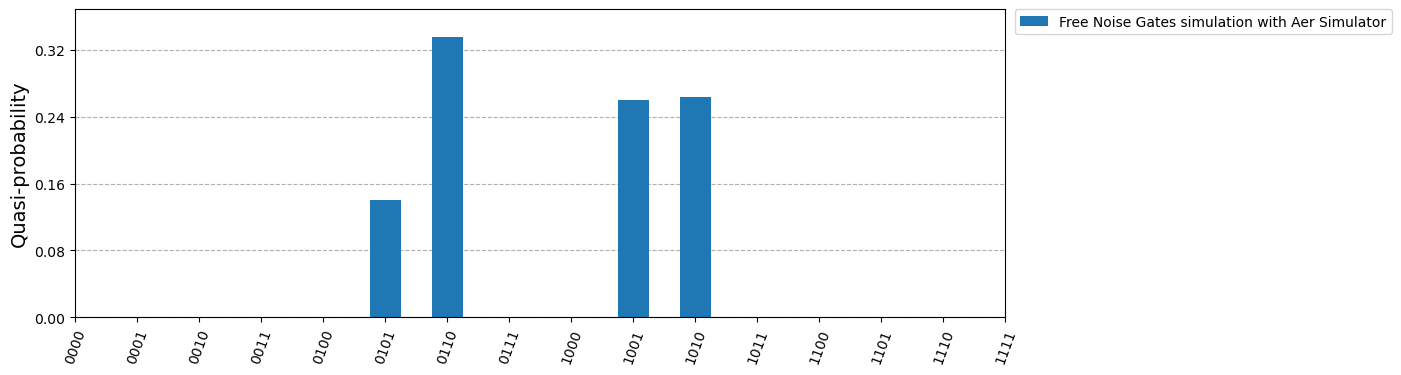

In [51]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noise_uccsd.values())

probs_full = {state: probs_free_aer_min_noise_uccsd.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noise_uccsd = quasi_probs_original

plot_histogram(probs_free_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [ ]:
probs_to_plot = [probs_noise_ander_min_noise_uccsd, probs_free_ander_min_noise_uccsd, probs_noise_aer_min_noise_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisy VQE with UCCSD'
filename = 'histo_noise_ucccsd'

plot_histogram(probs_to_plot, bar_labels=True, legend=legend, title=title, filename = filename)

Averaged groundstate energy (Hartree units): -0.6054685827884815


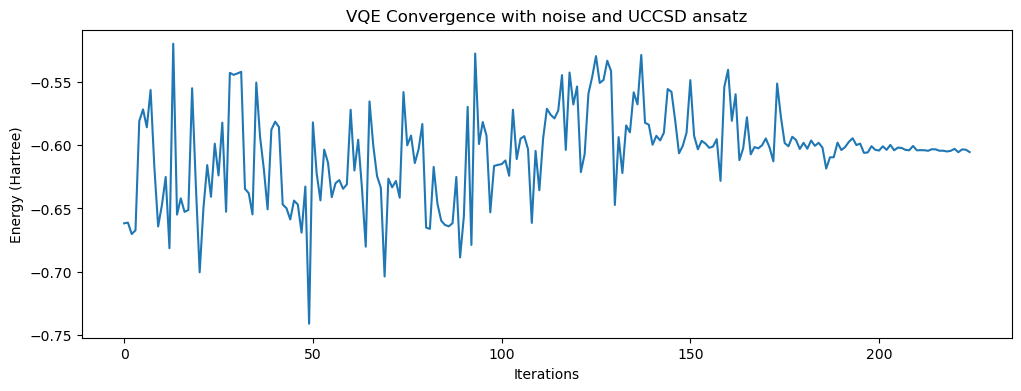

In [52]:
counts_noise_uccsd = np.arange(0, max_evaluations_noise_uccsd)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_uccsd, average_values_noise_uccsd, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and UCCSD ansatz")
pylab.savefig('vqe_noise_uccsd_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noise_uccsd[-1])


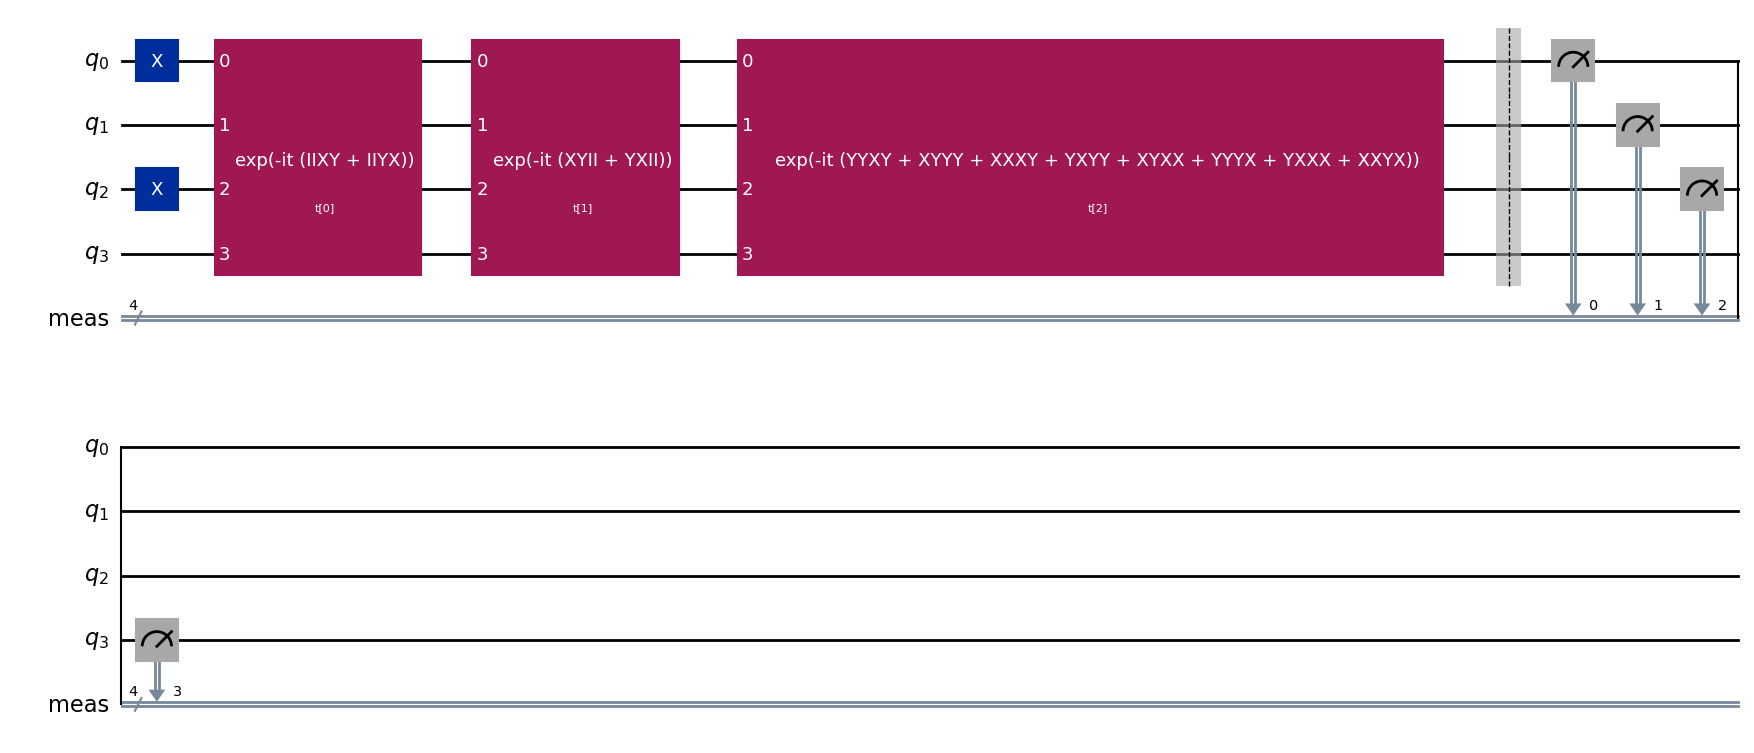

In [164]:
ansatz_circuit_min_noise_uccsd = optimal_circuit_noise_uccsd
ansatz_circuit_min_noise_uccsd = ansatz_circuit_min_noise_uccsd.decompose()  # Descompone las puertas en básicas
ansatz_circuit_min_noise_uccsd.measure_all()
ansatz_circuit_min_noise_uccsd.draw('mpl')

In [165]:
# transpilation of the circuit
t_circ_min_noise_uccsd = transpile(
    ansatz_circuit_min_noise_uccsd,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)
#t_circ_min_noise_uccsd = t_circ_min_noise_uccsd.assign_parameters(parameters_noise_uccsd)

vqe_result = vqe_solver_noise_uccsd._build_vqe_result(
    ansatz = vqe_solver_noise_uccsd.ansatz,
    optimizer_result = result_noise_uccsd.optimizer_result,
    aux_operators_evaluated = result_noise_uccsd.aux_operators_evaluated,
    optimizer_time = result_noise_uccsd.optimizer_time
    )
print(parameters_noise_uccsd)
print(vqe_result.optimal_parameters)
t_circ_min_noise_uccsd = t_circ_min_noise_uccsd.assign_parameters(vqe_result.optimal_parameters)

{ParameterVectorElement(t[0]): np.float64(210647.61172615847), ParameterVectorElement(t[1]): np.float64(-1031383.6469405502), ParameterVectorElement(t[2]): np.float64(-1198009.8989601447)}
{ParameterVectorElement(t[0]): np.float64(1004704.4353000482), ParameterVectorElement(t[1]): np.float64(-5123763.376063492), ParameterVectorElement(t[2]): np.float64(-5998695.530494567)}


In [121]:
probs_noise_ander_min_noise_uccsd = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noise_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

In [122]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noise_uccsd = fix_counts(probs_noise_ander_min_noise_uccsd, n_classic_bit)
hist=plot_histogram(counts_noise_ander_min_noise_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator and UCCSD after noisy VQE'])
hist.savefig('histogram_noisevqe_uccsd_noise_ander', dpi=100, bbox_inches='tight')


In [166]:
probs_free_ander_min_noise_uccsd = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noise_uccsd, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

In [167]:
measured_qubit = n_classic_bit
counts_free_ander_min_noise_uccsd = fix_counts(probs_free_ander_min_noise_uccsd, n_classic_bit)
hist=plot_histogram(counts_free_ander_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator and UCCSD after noisy VQE'])
hist.savefig('histogram_noisevqe_uccsd_free_ander', dpi=100, bbox_inches='tight')

In [125]:
probs_noise_aer_min_noise_uccsd = sim_noise_aer.run(t_circ_min_noise_uccsd, shots=10000).result()

In [126]:
counts_noise_aer_min_noise_uccsd = probs_noise_aer_min_noise_uccsd.get_counts()

total_counts = sum(counts_noise_aer_min_noise_uccsd.values())
quasi_probs = {state: counts_noise_aer_min_noise_uccsd / total_counts for state, counts_noise_aer_min_noise_uccsd in counts_noise_aer_min_noise_uccsd.items()}

counts_noise_aer_min_noise_uccsd = quasi_probs

hist=plot_histogram(counts_noise_aer_min_noise_uccsd, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator and UCCSD after noisy VQE'])
hist.savefig('histogram_noisevqe_uccsd_noise_aer', dpi=100, bbox_inches='tight')

In [162]:
probs_free_aer_min_noise_uccsd = sim_free_aer.run(t_circ_min_noise_uccsd, shots=10000).result()

In [163]:
counts_free_aer_min_noise_uccsd = probs_free_aer_min_noise_uccsd.get_counts()

all_states = [format(i, f'0{n_qubit}b') for i in range(2**n_qubit)]
full_counts = {state: 0 for state in all_states}
full_counts.update(counts_free_aer_min_noise_uccsd)
total_counts = sum(full_counts.values())
quasi_probs = {state: full_counts / total_counts for state, full_counts in full_counts.items()}

counts_free_aer_min_noise_uccsd = quasi_probs

hist=plot_histogram(counts_free_aer_min_noise_uccsd, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator and UCCSD after noisy VQE'])
hist.savefig('histogram_noisevqe_uccsd_free_aer', dpi=100, bbox_inches='tight')

##### WE DO THE SAME WITH tUPS


In [11]:
import qiskit_aer
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeTorino
import pyscf
import numpy as np
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.qiskit_interface.interface import QuantumInterface
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler as Sampler
from qiskit.primitives import StatevectorSampler as SamplerV2

from qiskit_aer.primitives import Sampler as SamplerAer
from qiskit_aer.primitives import SamplerV2 as SamplerV2Aer

from qiskit_ibm_runtime import Sampler as SamplerIBM #outdated
from qiskit_ibm_runtime import SamplerV2 as SamplerV2IBM
from qiskit_aer import AerSimulator
aer = AerSimulator()

In [12]:
estimator = Estimator()
mapper = JordanWignerMapper()
QI = QuantumInterface(estimator,"tUPS", mapper, ansatz_options={"n_layers":2}) #too many layers increase the deepness of the circuit and vqe calculations will take too long
ansatz_tups = QI.construct_circuit(num_orbs=es_problem.num_spatial_orbitals, num_elec=es_problem.num_particles)
ansatz_tups = QI.circuit
ansatz_tups.decompose()
ansatz_tups.measure_all()
print(type(ansatz_tups))
#ansatz_tups.draw('mpl')

Number of shots is None. Ideal simulator is assumed.
<class 'qiskit_nature.second_q.circuit.library.initial_states.hartree_fock.HartreeFock'>


/tmp/ipykernel_568/4008898128.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [15]:
t_circ_tups = transpile(
    ansatz_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=42,
    scheduling_method='asap'
)
print(t_circ_tups.parameters)
rng = np.random.default_rng(1271)
params_tups = rng.uniform(-np.pi, np.pi, size=t_circ_tups.num_parameters)
t_circ_tups = t_circ_tups.assign_parameters(params_tups)



ParameterView([Parameter(p000000000), Parameter(p000000001), Parameter(p000000002), Parameter(p000000003), Parameter(p000000004), Parameter(p000000005)])


In [18]:
probs_noise_ander_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit



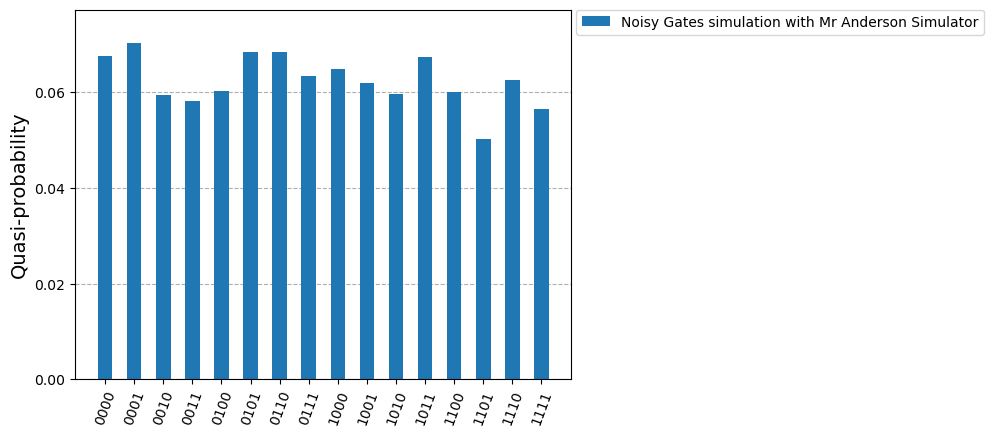

In [19]:
measured_qubit = n_classic_bit
counts_noise_ander_tups = fix_counts(probs_noise_ander_tups, n_classic_bit)
plot_histogram(counts_noise_ander_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

In [20]:
probs_free_ander_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) # here level opt is meaningless becaues we are using efficient circuit

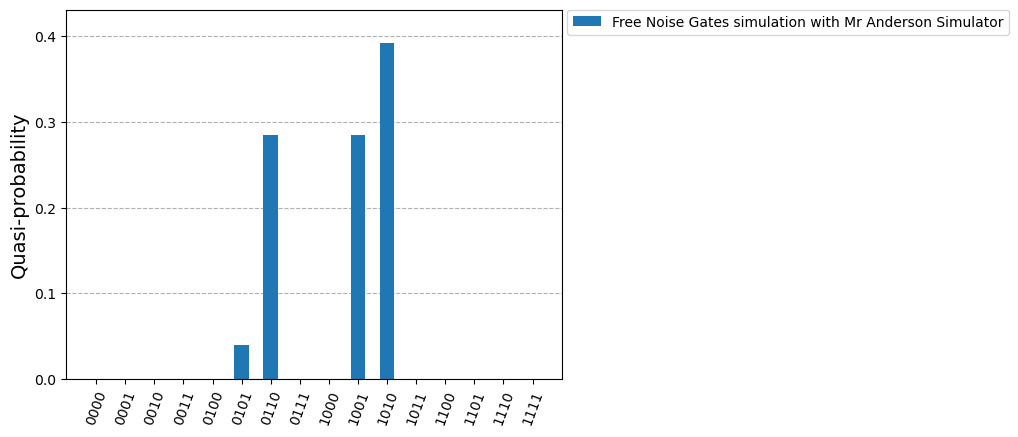

In [21]:
measured_qubit = n_classic_bit
counts_free_ander_tups = fix_counts(probs_free_ander_tups, n_classic_bit)
plot_histogram(counts_free_ander_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])

In [22]:
probs_noise_aer_tups = sim_noise_aer.run(t_circ_tups, shots=10000).result()

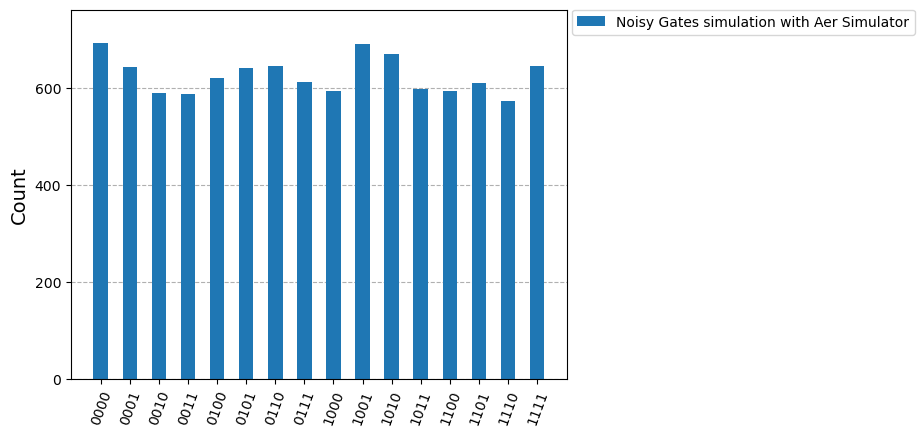

In [23]:
counts_noise_aer_tups = probs_noise_aer_tups.get_counts()
plot_histogram(counts_noise_aer_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])

In [24]:
probs_free_aer_tups = sim_free_aer.run(t_circ_tups, shots=10000).result()

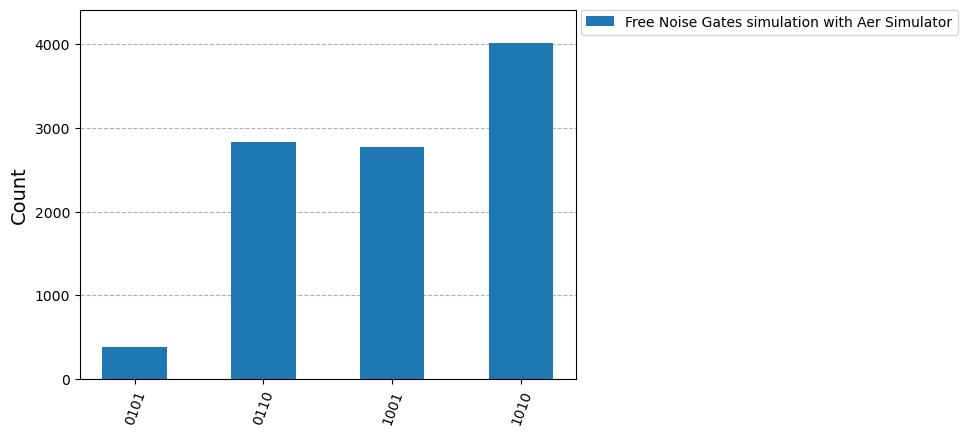

In [26]:
counts_free_aer_tups = probs_free_aer_tups.get_counts()

all_states = [format(i, f'0{n_qubit}b') for i in range(2**n_qubit)]
full_counts = {state: 0 for state in all_states}
full_counts.update(counts_free_aer_tups)

total_counts = sum(full_counts.values())
quasi_probs = {state: full_counts / total_counts for state, full_counts in full_counts.items()}

plot_histogram(counts_free_aer_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [19]:
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

average_values_noisefree_tups, probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_tups, probs_noise_aer_min_noisefree_tups, probs_free_aer_min_noisefree_tups, max_evaluations_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=100, maxiter=100, is_tUPS=True)


/tmp/ipykernel_568/3492561310.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  average_values_noisefree_tups, probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_tups, probs_noise_aer_min_noisefree_tups, probs_free_aer_min_noisefree_tups, max_evaluations_noisefree_tups = run_vqe_with_averaging(ansatz_tups, Estimator(), mapper, es_problem, n_repeats=100, maxiter=100, is_tUPS=True)


Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansa

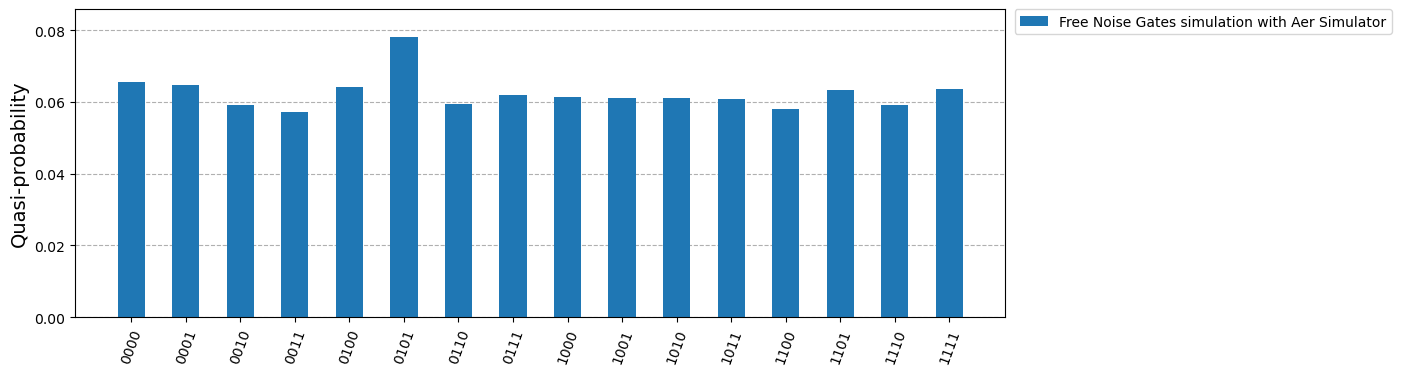

In [20]:
plot_histogram(probs_noise_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

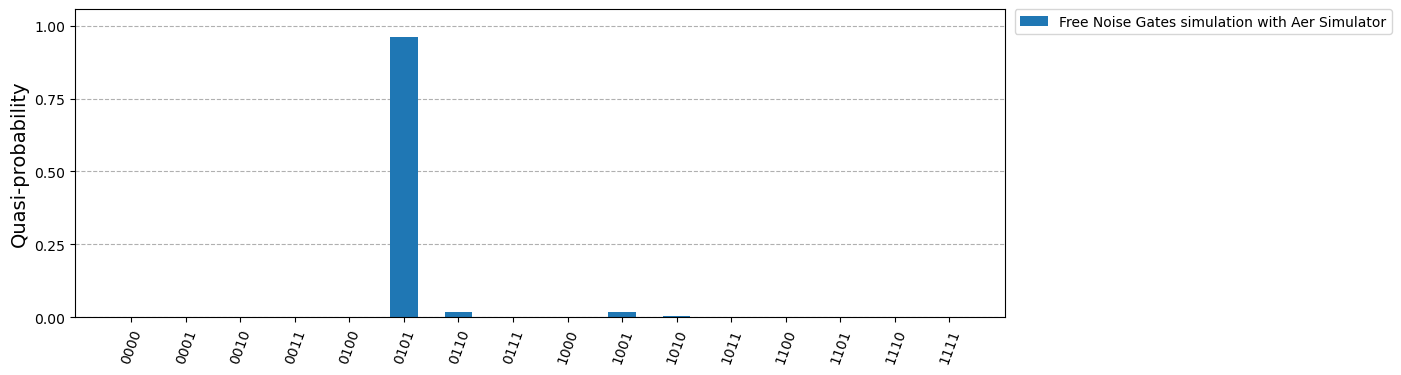

In [21]:
plot_histogram(probs_free_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [22]:
#plot_histogram(probs_noise_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

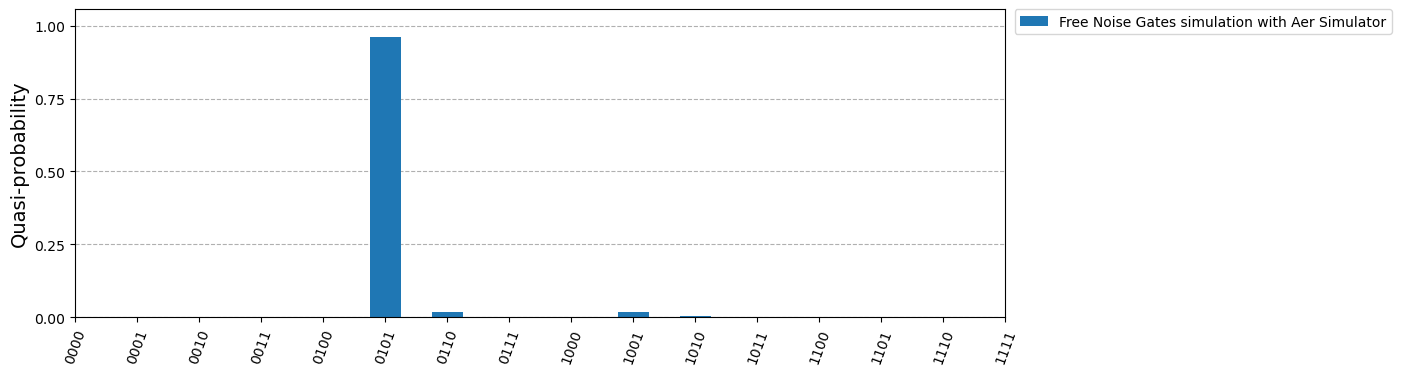

In [23]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noisefree_tups.values())

probs_full = {state: probs_free_aer_min_noisefree_tups.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noisefree_tups = quasi_probs_original
plot_histogram(probs_free_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [ ]:
probs_to_plot = [probs_noise_ander_min_noisefree_tups, probs_free_ander_min_noisefree_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisless VQE with tUPS'
filename = 'histo_noisefree_tups'

plot_histogram(probs_to_plot, bar_labels=True, legend=legend, title=title, filename = filename)

Averaged groundstate energy (Hartree units): -0.9453795298443999


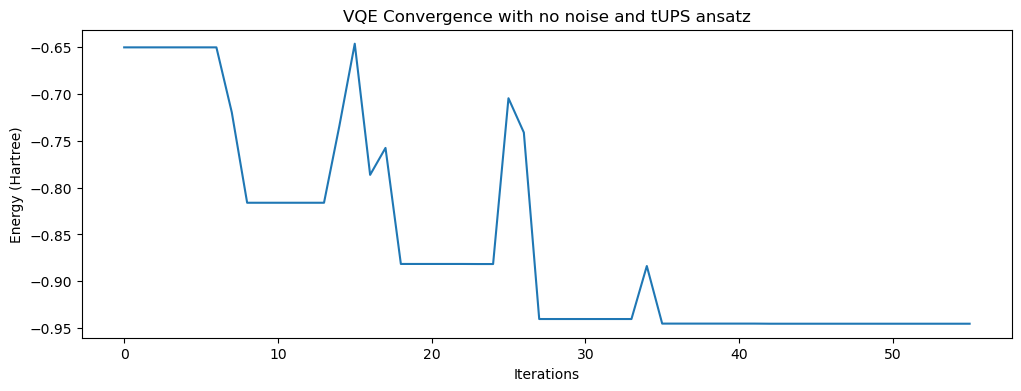

In [21]:
counts_noisefree_tups = np.arange(0, max_evaluations_noisefree_tups)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noisefree_tups, average_values_noisefree_tups, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with no noise and tUPS ansatz")
pylab.savefig('vqe_noisefree_tups_avg')

print("Averaged groundstate energy (Hartree units):", average_values_noisefree_tups[-1])


In [27]:
qubit_op = mapper.map(es_problem.second_q_ops()[0])  # Map second quantized Hamiltonian
n_qubits = qubit_op.num_qubits
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

vqe_solver = VQE(Estimator(), ansatz_tups, SLSQP(maxiter=100))
vqe_solver.initial_point = np.random.rand(ansatz_tups.num_parameters)

result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
      
vqe_result = vqe_solver._build_vqe_result(
    ansatz = vqe_solver.ansatz,
    optimizer_result = result.optimizer_result,
    aux_operators_evaluated = result.aux_operators_evaluated,
    optimizer_time = result.optimizer_time
    )

optimal_circuit_noisefree_tups = vqe_result.optimal_circuit

/tmp/ipykernel_305570/4286627878.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz_tups, SLSQP(maxiter=100))


In [28]:
ansatz_circuit_min_noisefree_tups = optimal_circuit_noisefree_tups
ansatz_circuit_min_noisefree_tups = ansatz_circuit_min_noisefree_tups.decompose() 
ansatz_circuit_min_noisefree_tups.measure_all()


In [29]:
#ansatz_circuit_min_noisefree_tups = ansatz_circuit_min_noisefree_tups.assign_parameters(parameters_noisefree_tups)

t_circ_min_noisefree_tups = transpile(
    ansatz_circuit_min_noisefree_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

#t_circ_min_noisefree_tups = t_circ_min_noisefree_tups.assign_parameters(parameters_noisefree_tups)

print(vqe_result.optimal_parameters)
t_circ_min_noisefree_tups = t_circ_min_noisefree_tups.assign_parameters(vqe_result.optimal_parameters)

{Parameter(p000000000): np.float64(1.3139407625165807), Parameter(p000000001): np.float64(1.0737424154070543), Parameter(p000000002): np.float64(-0.40054149550258616), Parameter(p000000003): np.float64(-0.5639449541659027), Parameter(p000000004): np.float64(1.6269377303565469), Parameter(p000000005): np.float64(-0.8013268244669768)}


In [30]:
probs_noise_ander_min_noisefree_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit)

In [31]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noisefree_tups = fix_counts(probs_noise_ander_min_noisefree_tups, n_classic_bit)
hist=plot_histogram(counts_noise_ander_min_noisefree_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator'])

hist.savefig('histogram_freevqe_tups_noise_ander', dpi=100, bbox_inches='tight')

In [32]:
probs_free_ander_min_noisefree_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noisefree_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

In [33]:
measured_qubit = n_classic_bit
counts_free_ander_min_noisefree_tups = fix_counts(probs_free_ander_min_noisefree_tups, n_classic_bit)
hist=plot_histogram(counts_free_ander_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator'])
hist.savefig('histogram_freevqe_tups_free_ander', dpi=100, bbox_inches='tight')

In [34]:
probs_noise_aer_min_noisefree_tups = sim_noise_aer.run(t_circ_min_noisefree_tups, shots=10000).result()

AerError: 'circuits have parameters but parameter_binds is not specified.'

In [158]:
counts_noise_aer_min_noisefree_tups = probs_noise_aer_min_noisefree_tups.get_counts()

total_counts = sum(counts_noise_aer_min_noisefree_tups.values())
quasi_probs = {state: counts_noise_aer_min_noisefree_tups / total_counts for state, counts_noise_aer_min_noisefree_tups in counts_noise_aer_min_noisefree_tups.items()}

counts_noise_aer_min_noisefree_tups = quasi_probs

hist=plot_histogram(counts_noise_aer_min_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator'])
hist.savefig('histogram_freevqe_tups_noise_aer', dpi=100, bbox_inches='tight')

NameError: name 'probs_noise_aer_min_noisefree_tups' is not defined

In [35]:
probs_free_aer_min_noisefree_tups = sim_free_aer.run(t_circ_min_noisefree_tups, shots=10000).result()

In [36]:
counts_free_aer_min_noisefree_tups = probs_free_aer_min_noisefree_tups.get_counts()

all_states = [format(i, f'0{n_qubit}b') for i in range(2**n_qubit)]
full_counts = {state: 0 for state in all_states}
full_counts.update(counts_free_aer_min_noisefree_tups)

total_counts = sum(full_counts.values())
quasi_probs = {state: full_counts / total_counts for state, full_counts in full_counts.items()}

counts_free_aer_min_noisefree_tups = quasi_probs

hist=plot_histogram(counts_free_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])
hist.savefig('histogram_freevqe_tups_free_aer', dpi=100, bbox_inches='tight')

In [13]:
backend_fake = FakeKyiv()
noise_model = NoiseModel.from_backend(backend_fake)
noisy_estimator =  AerEstimator(backend_options={
        "noise_model": noise_model,
    },)

In [14]:
ansatz_tups.remove_final_measurements() # we need this line, otherwise it'll not work

average_values_noise_tups, probs_noise_ander_min_noise_tups, probs_free_ander_min_noise_tups, probs_noise_aer_min_noise_tups, probs_free_aer_min_noise_tups, max_evaluations_noise_tups = run_vqe_with_averaging(ansatz_tups, noisy_estimator, mapper, es_problem, n_repeats=50, maxiter=100, is_tUPS=True)


Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansatz
Can't perform noisy Qiskit Aer simulation with tUPS ansa

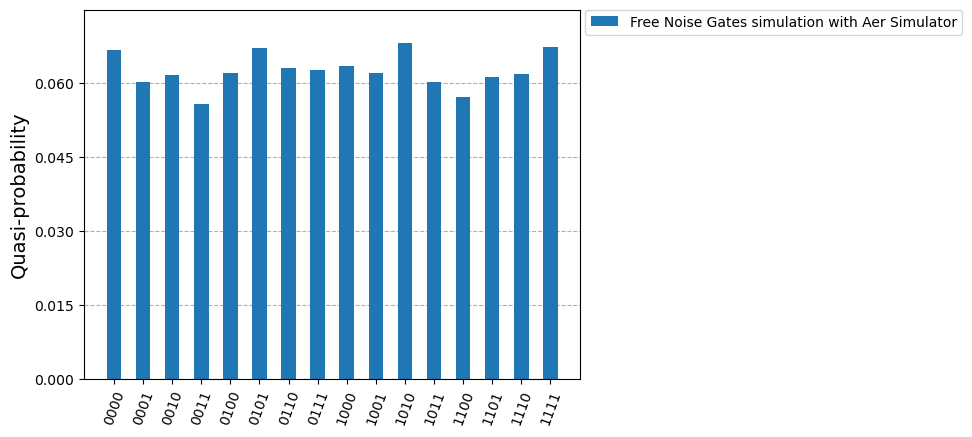

In [15]:
plot_histogram(probs_noise_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

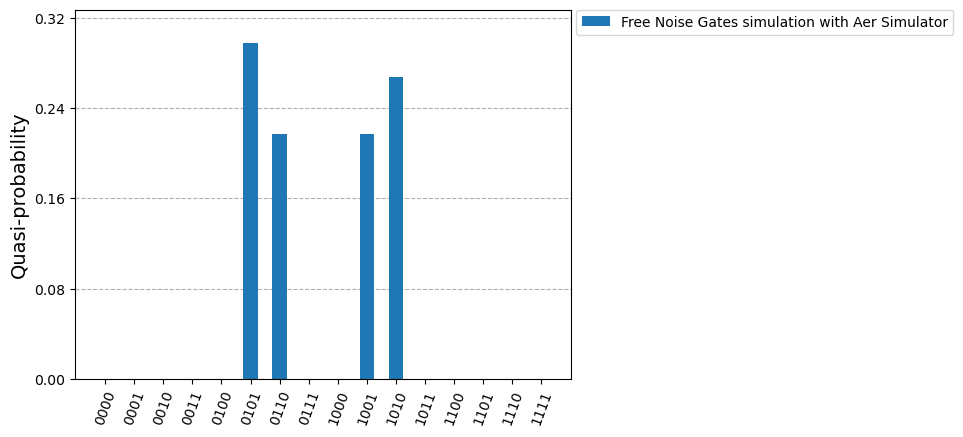

In [16]:
plot_histogram(probs_free_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [29]:
#plot_histogram(probs_noise_aer_min_noisefree_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

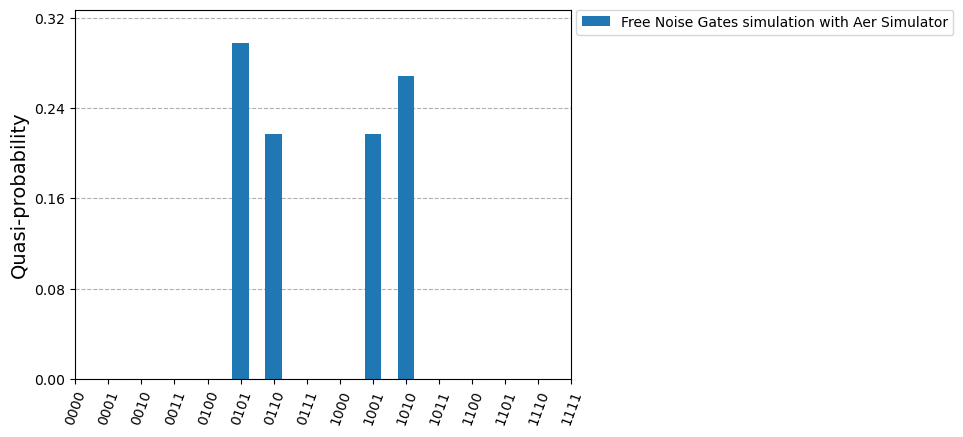

In [17]:
all_states = [''.join(state) for state in product('01', repeat=4)]

total_counts = sum(probs_free_aer_min_noise_tups.values())

probs_full = {state: probs_free_aer_min_noise_tups.get(state, 0) for state in all_states}
quasi_probs_original = {state: count / total_counts for state, count in probs_full.items()}

probs_free_aer_min_noise_tups = quasi_probs_original
plot_histogram(probs_free_aer_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator'])

In [ ]:
probs_to_plot = [probs_noise_ander_min_noise_tups, probs_free_ander_min_noise_uccsd]

legend = ['Mr Anderson','Noisless','Qiskit']
title = 'Probability distribution for ground state after noisy VQE with tUPS'
filename = 'histo_noise_tups'

plot_histogram(probs_to_plot, bar_labels=True, legend=legend, title=title, filename = filename)

Averaged groundstate energy (Hartree units): -0.5941664812463854


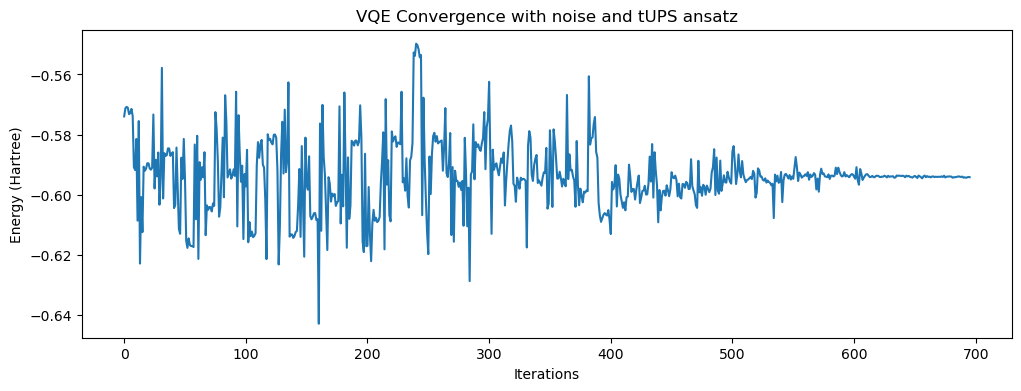

In [18]:
counts_noise_tups = np.arange(0, max_evaluations_noise_tups)
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts_noise_tups, average_values_noise_tups, label="Average Energy")
pylab.xlabel("Iterations")
pylab.ylabel("Energy (Hartree)")
pylab.title("VQE Convergence with noise and tUPS ansatz")
pylab.savefig('vqe_noise_tups_avg_try')

print("Averaged groundstate energy (Hartree units):", average_values_noise_tups[-1])


In [95]:
ansatz_circuit_min_noise_tups = optimal_circuit_noise_tups
ansatz_circuit_min_noise_tups = ansatz_circuit_min_noise_tups.decompose()  # Descompone las puertas en básicas
ansatz_circuit_min_noise_tups.measure_all()
#ansatz_circuit_min_noise_tups.draw('mpl')

In [96]:
t_circ_min_noise_tups = transpile(
    ansatz_circuit_min_noise_tups,
    backend_fake,
    initial_layout=linear_qubit_layout,
    seed_transpiler=10,
    scheduling_method='asap'
)

#t_circ_min_noise_tups = t_circ_min_noise_tups.assign_parameters(parameters_noise_tups)

vqe_result = vqe_solver_noise_tups._build_vqe_result(
    ansatz = vqe_solver_noise_tups.ansatz,
    optimizer_result = result_noise_tups.optimizer_result,
    aux_operators_evaluated = result_noise_tups.aux_operators_evaluated,
    optimizer_time = result_noise_tups.optimizer_time
    )
print(parameters_noise_tups)
print(vqe_result.optimal_parameters)
t_circ_min_noise_tups = t_circ_min_noise_tups.assign_parameters(vqe_result.optimal_parameters)

{Parameter(p000000000): np.float64(-11196.07950862265), Parameter(p000000001): np.float64(21349.808824045485), Parameter(p000000002): np.float64(-7030.6757607898235)}
{Parameter(p000000000): np.float64(22343.088662858747), Parameter(p000000001): np.float64(84596.43758723224), Parameter(p000000002): np.float64(48913.995468838504)}


In [101]:
probs_noise_ander_min_noise_tups = sim_noise_ander.run(
    t_qiskit_circ=t_circ_min_noise_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit)


In [102]:
print(probs_noise_ander_min_noise_tups)

{'00000000': np.float64(0.08507244725656782), '01000100': np.float64(0.04428676708260012), '10001000': np.float64(0.0687274185512134), '11001100': np.float64(0.03350102029160381), '00100010': np.float64(0.07508379756210026), '01100110': np.float64(0.09844973440694098), '10101010': np.float64(0.103452820125172), '11101110': np.float64(0.051822846327048006), '00010001': np.float64(0.08014809094270971), '01010101': np.float64(0.059080857647626), '10011001': np.float64(0.10779304250007235), '11011101': np.float64(0.03811361580793687), '00110011': np.float64(0.03566452792603776), '01110111': np.float64(0.036928631522315916), '10111011': np.float64(0.05111165906438774), '11111111': np.float64(0.030762722985667318)}


In [23]:
measured_qubit = n_classic_bit
counts_noise_ander_min_noise_tups = fix_counts(probs_noise_ander_min_noise_tups, n_classic_bit)
hist=plot_histogram(counts_noise_ander_min_noise_tups, bar_labels=False, legend=['Noisy Gates simulation with Mr Anderson Simulator and tUPS after noisy VQE'])
hist.savefig('histogram_noisevqe_tups_noise_ander', dpi=100, bbox_inches='tight')

In [97]:
probs_free_ander_min_noise_tups = sim_free_ander.run(
    t_qiskit_circ=t_circ_min_noise_tups, 
    qubits_layout=linear_qubit_layout, 
    psi0=np.array(psi0), 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=n_qubit) 

In [98]:
measured_qubit = n_classic_bit
counts_free_ander_min_noise_tups = fix_counts(probs_free_ander_min_noise_tups, n_classic_bit)
hist=plot_histogram(counts_free_ander_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Mr Anderson Simulator and tUPS after noisy VQE'])
hist.savefig('histogram_noisevqe_tups_free_ander', dpi=100, bbox_inches='tight')

In [32]:
probs_noise_aer_min_noise_tups = sim_noise_aer.run(t_circ_min_noise_tups, shots=10000).result()

In [33]:
counts_noise_aer_min_noise_tups = probs_noise_aer_min_noise_tups.get_counts()

total_counts = sum(counts_noise_aer_min_noise_tups.values())
quasi_probs = {state: counts_noise_aer_min_noise_tups / total_counts for state, counts_noise_aer_min_noise_tups in counts_noise_aer_min_noise_tups.items()}

counts_noise_aer_min_noise_tups = quasi_probs

hist=plot_histogram(counts_noise_aer_min_noise_tups, bar_labels=False, legend=['Noisy Gates simulation with Aer Simulator and tUPS after noisy VQE'])
hist.savefig('histogram_noisevqe_tups_noise_aer', dpi=100, bbox_inches='tight')

In [30]:
probs_free_aer_min_noise_tups = sim_free_aer.run(t_circ_min_noise_tups, shots=10000).result()

In [31]:
counts_free_aer_min_noise_tups = probs_free_aer_min_noise_tups.get_counts()

all_states = [format(i, f'0{n_qubit}b') for i in range(2**n_qubit)]
full_counts = {state: 0 for state in all_states}
full_counts.update(counts_free_aer_min_noise_tups)

total_counts = sum(full_counts.values())
quasi_probs = {state: full_counts / total_counts for state, full_counts in full_counts.items()}

counts_free_aer_min_noise_tups = quasi_probs

hist=plot_histogram(counts_free_aer_min_noise_tups, bar_labels=False, legend=['Free Noise Gates simulation with Aer Simulator and tUPS after noisy VQE'])
hist.savefig('histogram_noisevqe_tups_free_aer', dpi=100, bbox_inches='tight')

In [7]:
backend = FakeKyiv()
#backend = provider.backend('ibm_kyiv')
print(backend.qubit_properties(0))
print(backend.qubit_properties(1))
print(backend.qubit_properties(2))
print(backend.qubit_properties(3))
config = backend.configuration()
print("Número de qubits:", config.n_qubits)

QubitProperties(t1=0.00036403810294451946, t2=0.00034854936444011657, frequency=4655609332.053975)
QubitProperties(t1=0.0005690055349559576, t2=0.00023207678408770585, frequency=4534975859.426203)
QubitProperties(t1=0.0003052640970754664, t2=0.0001197420446260147, frequency=4680110183.2333765)
QubitProperties(t1=0.00034493619450739663, t2=0.0001656597804188118, frequency=4606655659.877273)
Número de qubits: 127


In [3]:
properties = backend.properties()
for qubit, qubit_props in enumerate(properties.qubits):
    t1 = qubit_props[0].value  # T1
    t2 = qubit_props[1].value  # T2
    print(f"Qubit {qubit}: T1={t1:.2e} s, T2={t2:.2e} s")

Qubit 0: T1=3.64e+02 s, T2=3.49e+02 s
Qubit 1: T1=5.69e+02 s, T2=2.32e+02 s
Qubit 2: T1=3.05e+02 s, T2=1.20e+02 s
Qubit 3: T1=3.45e+02 s, T2=1.66e+02 s
Qubit 4: T1=4.37e+02 s, T2=1.11e+02 s
Qubit 5: T1=2.21e+02 s, T2=3.05e+02 s
Qubit 6: T1=3.89e+02 s, T2=1.92e+02 s
Qubit 7: T1=4.21e+02 s, T2=3.71e+02 s
Qubit 8: T1=3.64e+02 s, T2=2.53e+02 s
Qubit 9: T1=4.82e+02 s, T2=5.08e+01 s
Qubit 10: T1=2.72e+02 s, T2=4.91e+01 s
Qubit 11: T1=3.81e+02 s, T2=3.25e+02 s
Qubit 12: T1=4.50e+02 s, T2=3.06e+02 s
Qubit 13: T1=3.55e+02 s, T2=7.77e+01 s
Qubit 14: T1=2.94e+02 s, T2=1.97e+02 s
Qubit 15: T1=4.30e+02 s, T2=7.53e+01 s
Qubit 16: T1=1.19e+02 s, T2=9.04e+01 s
Qubit 17: T1=1.97e+02 s, T2=4.80e+01 s
Qubit 18: T1=3.74e+02 s, T2=5.32e+01 s
Qubit 19: T1=2.18e+02 s, T2=2.07e+02 s
Qubit 20: T1=4.83e+02 s, T2=4.37e+02 s
Qubit 21: T1=4.03e+02 s, T2=7.77e+01 s
Qubit 22: T1=3.90e+02 s, T2=1.47e+02 s
Qubit 23: T1=2.56e+02 s, T2=1.38e+02 s
Qubit 24: T1=3.19e+02 s, T2=8.99e+01 s
Qubit 25: T1=2.27e+02 s, T2=2.62e+0